# Trying out Minigrad

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import random
from minigrad.engine import Value
from minigrad.nn import MLP


In [64]:
np.random.seed(1337)
random.seed(1337)


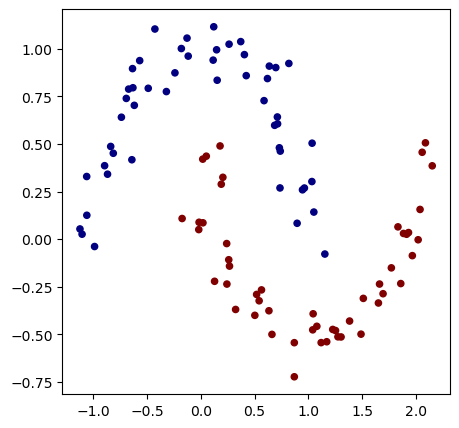

In [67]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [69]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network with 16 neurons each
print(model)
print("number of parameters", len(model.parameters()))

number of parameters 337
